# Mid-Ratio Histogram Test

In this section, we take a closer look at the authors' mid ratio test. They look at the ordered triplet (a,b,c); a < b < c and plot the ratio of (b-a)/(c-a) and show an anomaly for the particular RTS. We will conduct the following tests:

To Do - Various plots that we will plot in this section

- First, try to reproduce what the authors did. Figure (1)

- Second, we pool in all the data and try to test for anomalous patterns by singling out each individual from the pool and plotting it compared to the rest of them put together excluding/including the individual?

- Third, we do a permutation test, by making random draws of N_RTS samples from the pooled data (all users) and calibrating the empirical distribution of mid ratio in such a random draw, and then testing for the surprising behavior of the "RTS"'s test statistic.

In [1]:
# import numpy and matlab plot library

import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt



In [2]:
# import panda
import pandas as pd


In [3]:
df = pd.read_excel("data/Bishayee Colony Counts 10.27.97-3.8.01.xlsx", na_values = [' '], header = 0, skiprows = [1,2], parse_cols = ("D:F"))
data = df.dropna(axis = 0)
data = data.as_matrix()

In [4]:
print data.shape

(1361, 3)


In [5]:
data[0,:]

array([ 78.,  91.,  93.])

In [6]:
data.sort(axis=1)
print data

[[ 78.  91.  93.]
 [ 88.  90.  90.]
 [ 66.  69.  80.]
 ..., 
 [ 59.  66.  78.]
 [ 44.  51.  60.]
 [ 23.  33.  40.]]


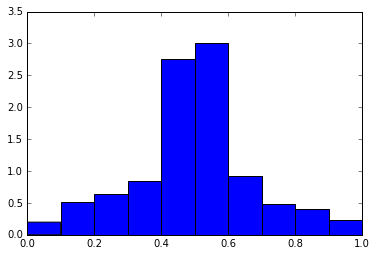

In [15]:
mid_min = data[:, 1] - data[:, 0]
max_min = data[:, 2] - data[:, 0]

ratio = ([mid_min[t]/max_min[t] for t in range(max_min.shape[0]) if max_min[t] !=0 ])

plt.hist(ratio, bins=10, normed = True)
plt.show()

In [75]:
v = np.zeros(10)
N = len(ratio)
v[0] = np.sum([( x <= 0.1) for x in ratio])
for i in range(2, 11):
    thr = float(i) /10.
    v[i-1] = np.sum([( x <= thr and x > thr-0.1) for x in ratio])

v /= np.sum(v)
x = np.linspace(0,1,10,endpoint=False)
plt.bar(x, v, width=0.1)

<Container object of 10 artists>

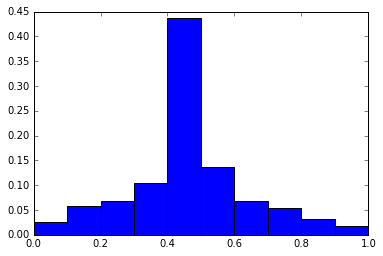